## Task Overview

### Objective:

Build a complete data pipeline to analyze IMDB-style Book Data using Python, SQL, and a visualization dashboard.

Deliverables:

Data Ingestion\
Load mock book data from a CSV file or simulate data from an API using Python.\
Data Cleaning\
Handle missing values, duplicates, and outliers in book-related fields such as ratings, votes, and publication year.\
SQL Schema Design and Population\
Design a normalized database schema for storing the book data using SQLite or PostgreSQL.\
Populate the database using the cleaned dataset.\
Interactive Dashboard (Streamlit or Dash)\
Build a web-based dashboard that allows users to filter and visualize:\
Average book ratings by genre\
Top-rated books by year\
Revenue vs. votes\
Book count by genre over the years

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data loading

In [4]:
# Generate mock book data
n = 10000

df = pd.DataFrame({
    'BookID': np.arange(n),
    'Title': [f'Book {i}' for i in range(n)],
    'Genre': np.random.choice(['Fiction', 'Mystery', 'Science Fiction', 'Romance', 'Non-Fiction'], size=n),
    'PublicationYear': np.random.randint(1950, 2024, size=n),
    'Rating': np.round(np.random.normal(loc=4.0, scale=0.7, size=n), 1),  # Book ratings typically range from 1 to 5
    'Votes': np.random.randint(10, 50000, size=n),
    'RevenueMillions': np.round(np.random.uniform(0.1, 50, size=n), 2)  # Simulated book sales revenue in millions
})

In [5]:
df.head()

,BookID,Title,Genre,PublicationYear,Rating,Votes,RevenueMillions
0,0,Book 0,Romance,2019,4.3,19403,9.83
1,1,Book 1,Mystery,2000,4.8,41885,19.40
2,2,Book 2,Non-Fiction,2000,3.1,39842,37.58
3,3,Book 3,Non-Fiction,1984,3.0,9518,12.03
4,4,Book 4,Fiction,1971,2.6,44514,47.99


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BookID           10000 non-null  int64  
 1   Title            10000 non-null  object 
 2   Genre            10000 non-null  object 
 3   PublicationYear  10000 non-null  int64  
 4   Rating           10000 non-null  float64
 5   Votes            10000 non-null  int64  
 6   RevenueMillions  10000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 547.0+ KB


# Data Cleaning

In [7]:
# convert Rating type to int after rounding
df['Rating'] = df['Rating'].clip(1, 5)  # Ensure ratings are within 1 to 5
df['Rating'] = df['Rating'].round().astype(int)

In [8]:
df['Rating'].value_counts().sort_index()

Rating
1       1
2     198
3    1980
4    5733
5    2088
Name: count, dtype: int64

In [9]:
df.head()

,BookID,Title,Genre,PublicationYear,Rating,Votes,RevenueMillions
0,0,Book 0,Romance,2019,4,19403,9.83
1,1,Book 1,Mystery,2000,5,41885,19.40
2,2,Book 2,Non-Fiction,2000,3,39842,37.58
3,3,Book 3,Non-Fiction,1984,3,9518,12.03
4,4,Book 4,Fiction,1971,3,44514,47.99


In [10]:
df[['PublicationYear', 'Votes', 'RevenueMillions']].describe()

,PublicationYear,Votes,RevenueMillions
count,10000.000000,10000.000000,10000.000000
mean,1986.473500,24894.880100,25.078733
std,21.560292,14427.820753,14.372880
min,1950.000000,17.000000,0.110000
25%,1968.000000,12311.750000,12.617500
50%,1987.000000,25059.000000,24.930000
75%,2005.000000,37324.500000,37.532500
max,2023.000000,49999.000000,49.980000


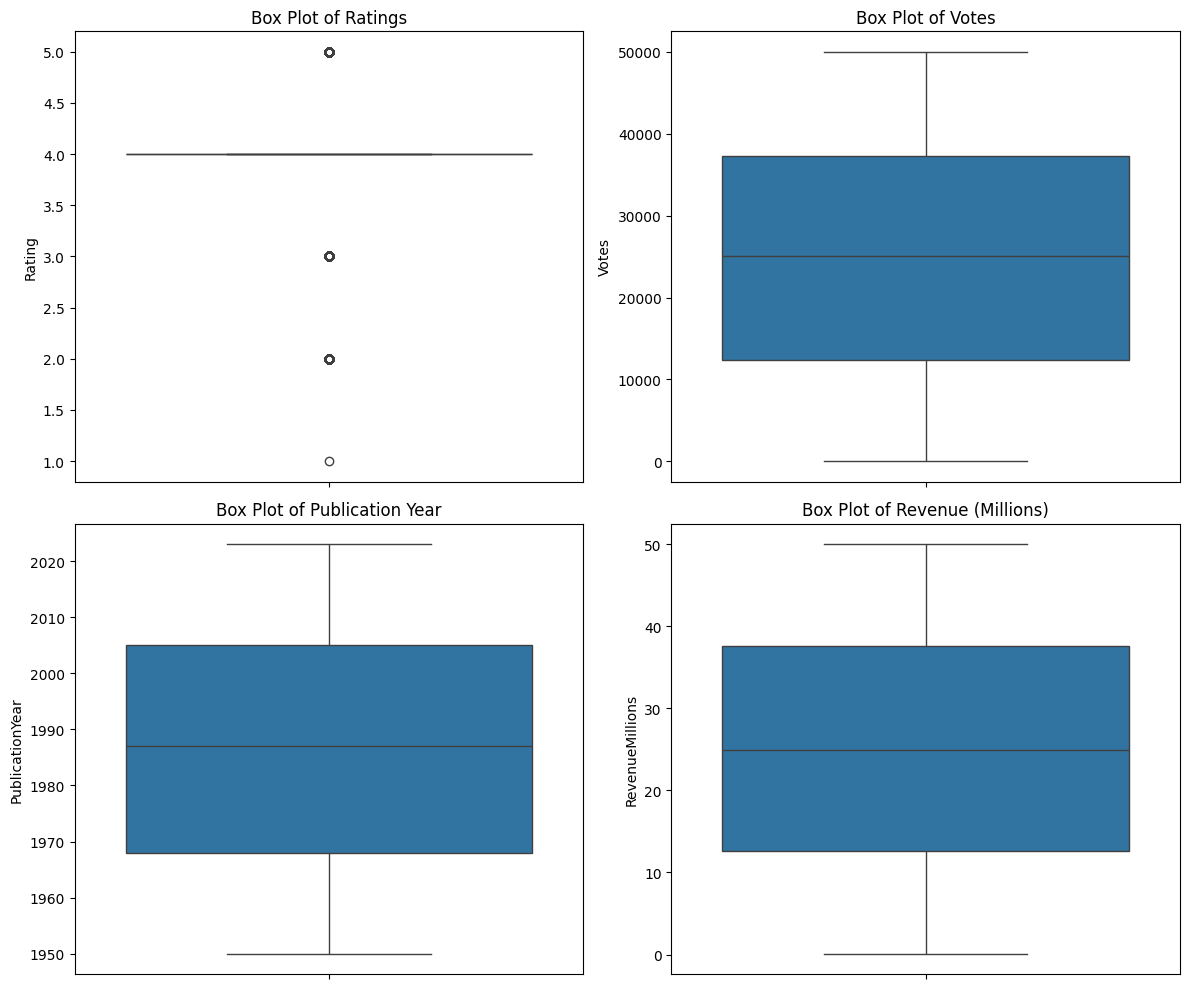

In [11]:
# Draw box plots for Rating, Votes, PublicationYear, RevenueMillions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(y=df['Rating'], ax=axes[0, 0])
sns.boxplot(y=df['Votes'], ax=axes[0, 1])
sns.boxplot(y=df['PublicationYear'], ax=axes[1, 0])
sns.boxplot(y=df['RevenueMillions'], ax=axes[1, 1])
axes[0, 0].set_title('Box Plot of Ratings')
axes[0, 1].set_title('Box Plot of Votes')
axes[1, 0].set_title('Box Plot of Publication Year')
axes[1, 1].set_title('Box Plot of Revenue (Millions)')
plt.tight_layout()
plt.show()

<Axes: xlabel='Rating', ylabel='Count'>

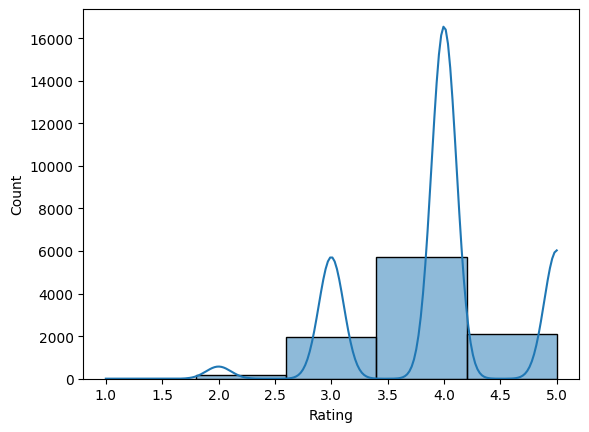

In [12]:
# create histogram
sns.histplot(df['Rating'], bins=5, kde=True)

In [13]:
# Check duplicated books based on BookID and Title
print(df.duplicated(['BookID', 'Title'], keep=False).sum())

0


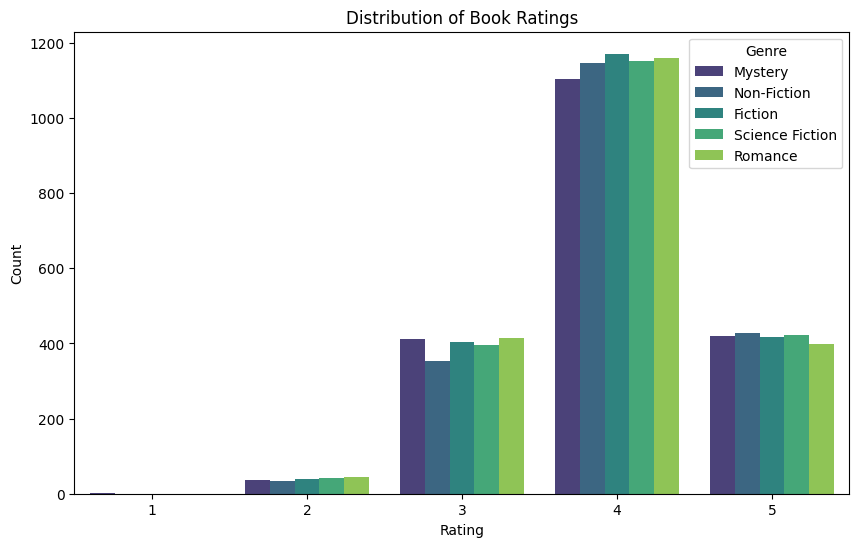

In [14]:
# plot the distribution of book ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Rating', palette='viridis', hue='Genre')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

array([[<Axes: title={'center': 'PublicationYear'}>,
        <Axes: title={'center': 'Votes'}>],
       [<Axes: title={'center': 'RevenueMillions'}>, <Axes: >]],
      dtype=object)

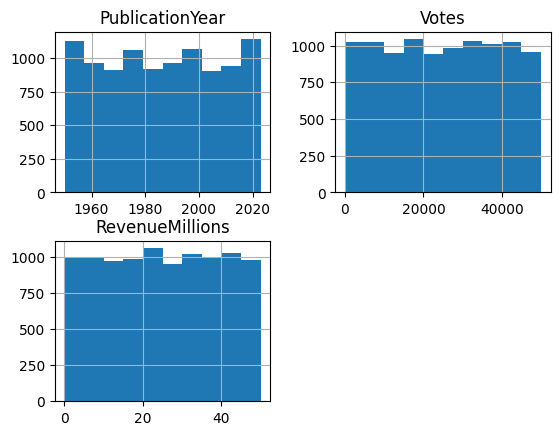

In [15]:
df[['PublicationYear', 'Votes', 'RevenueMillions']].hist()

# Database

In [16]:
import os
import sqlite3

DB_DIR = "outputs"
os.makedirs(DB_DIR, exist_ok=True)
db_path = os.path.join(DB_DIR, "books.db")

conn = sqlite3.connect(db_path)
cur = conn.cursor()

In [17]:

# Create tables: genres, books
cur.execute("PRAGMA foreign_keys = ON;")
cur.execute("""
CREATE TABLE IF NOT EXISTS genres (
    genre_id INTEGER PRIMARY KEY AUTOINCREMENT,
    genre_name TEXT UNIQUE NOT NULL
);
""")
cur.execute("""
CREATE TABLE IF NOT EXISTS books (
    book_id INTEGER PRIMARY KEY,
    title TEXT NOT NULL,
    genre_id INTEGER,
    publication_year INTEGER,
    rating INTEGER,
    votes INTEGER,
    revenue_millions REAL,
    FOREIGN KEY (genre_id) REFERENCES genres(genre_id)
);
""")
conn.commit()

In [18]:
# Insert genres
genres = df['Genre'].unique().tolist()
for g in genres:
    cur.execute("INSERT OR IGNORE INTO genres (genre_name) VALUES (?);", (g,))
conn.commit()

In [19]:
# Build mapping genre_name -> genre_id
cur.execute("SELECT genre_id, genre_name FROM genres;")
rows = cur.fetchall()
genres_list = [(r[0], r[1]) for r in rows]
genre_map = {name: gid for gid, name in genres_list}

In [20]:
genre_map

{'Science Fiction': 1,
 'Fiction': 2,
 'Romance': 3,
 'Mystery': 4,
 'Non-Fiction': 5}

In [21]:
# Insert books (use executemany in batches)
insert_sql = """
INSERT OR REPLACE INTO books
(book_id, title, genre_id, publication_year, rating, votes, revenue_millions)
VALUES (?, ?, ?, ?, ?, ?, ?);
"""
batch = []
for _, row in df.iterrows():
    gid = genre_map.get(row['Genre'])
    batch.append((int(row['BookID']), row['Title'], gid, int(row['PublicationYear']),
                    int(row['Rating']), int(row['Votes']), float(row['RevenueMillions'])))
    if len(batch) >= 1000:
        cur.executemany(insert_sql, batch)
        conn.commit()
        batch = []
if batch:
    cur.executemany(insert_sql, batch)
    conn.commit()

In [22]:
# Verify data insertion
cur.execute("SELECT * FROM books LIMIT 10;").fetchall()

[(0, 'Book 0', 3, 2019, 4, 19403, 9.83),
 (1, 'Book 1', 4, 2000, 5, 41885, 19.4),
 (2, 'Book 2', 5, 2000, 3, 39842, 37.58),
 (3, 'Book 3', 5, 1984, 3, 9518, 12.03),
 (4, 'Book 4', 2, 1971, 3, 44514, 47.99),
 (5, 'Book 5', 2, 2000, 4, 23714, 27.66),
 (6, 'Book 6', 3, 1987, 3, 23388, 4.82),
 (7, 'Book 7', 4, 1996, 3, 5524, 31.77),
 (8, 'Book 8', 1, 2014, 3, 47213, 6.47),
 (9, 'Book 9', 5, 1951, 5, 9834, 9.06)]

In [23]:
conn.close()

In [25]:
print(df.head())

   BookID   Title        Genre  PublicationYear  Rating  Votes  \
0       0  Book 0      Romance             2019       4  19403   
1       1  Book 1      Mystery             2000       5  41885   
2       2  Book 2  Non-Fiction             2000       3  39842   
3       3  Book 3  Non-Fiction             1984       3   9518   
4       4  Book 4      Fiction             1971       3  44514   

   RevenueMillions  
0             9.83  
1            19.40  
2            37.58  
3            12.03  
4            47.99  


# Dasboard

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, dash_table

# Build Dash app
app = Dash(__name__, suppress_callback_exceptions=True)
app.title = "Book Analytics Dashboard"

genres = sorted(df['Genre'].unique().tolist())
min_year, max_year = int(df['PublicationYear'].min()), int(df['PublicationYear'].max())

# ------------------------------------------------------------------
# Layout
app.layout = html.Div([
    html.H1("Book Analytics Dashboard"),

    html.Div([
        html.Div([
            html.Label("Select Genres"),
            dcc.Dropdown(
                options=[{'label': g, 'value': g} for g in genres],
                value=genres, # default all selected
                multi=True,
                id='genre-filter'
            ),
        ], style={'width': '45%', 'display': 'inline-block', 'verticalAlign': 'top'}),

        html.Div([
            html.Label("Publication Year Range"),
            dcc.RangeSlider(
                id='year-range',
                min=min_year,
                max=max_year,
                value=[min_year, max_year],
                marks={y: str(y) if y % 10 == 0 else '' for y in range(min_year, max_year+1)},
                step=1 
            ),
            html.Div(id='year-range-output', style={'marginTop': 10})
        ], style={'width': '50%', 'display': 'inline-block', 'paddingLeft': '20px'})
    ], style={'marginBottom': 30}),

    html.Div([
        html.Div([dcc.Graph(id='avg-rating-genre')], style={'width': '48%', 'display': 'inline-block'}),
        html.Div([dcc.Graph(id='revenue-vs-votes')], style={'width': '48%', 'display': 'inline-block', 'float': 'right'})
    ]),

    html.Div([
        dcc.Graph(id='count-genre-years')
    ], style={'marginTop': 30}),

    html.Div([
        html.H3("Top-rated books"),
        html.Div([
            html.Label("Select Year for Top Books"),
            dcc.Dropdown(
                options=[{'label': 'All Years', 'value': 'ALL'}] +
                        [{'label': str(y), 'value': str(y)} for y in range(min_year, max_year+1)],
                value='ALL',
                id='top-year-dropdown'
            ),
        ], style={'width': '30%'}),
        html.Div(id='top-books-table', style={'marginTop': 10})
    ], style={'marginTop': 30, 'marginBottom': 60})
], style={'width': '95%', 'margin': 'auto'})

# Callbacks
@app.callback(
    Output('year-range-output', 'children'),
    Input('year-range', 'value')
)
def update_year_text(year_range):
    return f"Showing books published between {year_range[0]} and {year_range[1]}"

@app.callback(
    Output('avg-rating-genre', 'figure'),
    Input('genre-filter', 'value'),
    Input('year-range', 'value')
)
def update_avg_rating(genres_selected, year_range):
    dff = df[
        (df['Genre'].isin(genres_selected)) &
        (df['PublicationYear'].between(year_range[0], year_range[1]))
    ]
    grouped = dff.groupby('Genre').agg(avg_rating=('Rating', 'mean'), count=('BookID', 'count')).reset_index()
    fig = px.bar(grouped, x='Genre', y='avg_rating', text='count',
                 title="Average Book Rating by Genre",
                 labels={'avg_rating': 'Average Rating', 'Genre': 'Genre'})
    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.update_layout(yaxis=dict(range=[0, 5]))
    return fig

@app.callback(
    Output('revenue-vs-votes', 'figure'),
    Input('genre-filter', 'value'),
    Input('year-range', 'value')
)
def update_revenue_vs_votes(genres_selected, year_range):
    dff = df[
        (df['Genre'].isin(genres_selected)) &
        (df['PublicationYear'].between(year_range[0], year_range[1]))
    ]
    fig = px.scatter(dff, x='Votes', y='RevenueMillions',
                     title="Revenue vs Votes",
                     labels={'Votes': 'Votes', 'RevenueMillions': 'Revenue (Millions)'})
    return fig

@app.callback(
    Output('count-genre-years', 'figure'),
    Input('genre-filter', 'value'),
    Input('year-range', 'value')
)
def update_count_genre_years(genres_selected, year_range):
    dff = df[
        (df['Genre'].isin(genres_selected)) &
        (df['PublicationYear'].between(year_range[0], year_range[1]))
    ]
    grouped = dff.groupby(['PublicationYear', 'Genre']).size().reset_index(name='Count')
    fig = px.line(grouped, x='PublicationYear', y='Count', color='Genre',
                  title="Book Count by Genre Over Years",
                  labels={'Count': 'Book Count', 'PublicationYear': 'Year'})
    return fig

@app.callback(
    Output('top-books-table', 'children'),
    Input('top-year-dropdown', 'value'),
    Input('genre-filter', 'value'),
    Input('year-range', 'value')
)
def update_top_books(selected_year, genres_selected, year_range):
    dff = df[
        (df['Genre'].isin(genres_selected)) &
        (df['PublicationYear'].between(year_range[0], year_range[1]))
    ]
    if selected_year != 'ALL':
        dff = dff[dff['PublicationYear'] == int(selected_year)]
    top_books = dff.sort_values(['Rating', 'Votes'], ascending=[False, False]).head(20)
    if top_books.empty:
        return html.Div("No books found for the selected filters.")

    table = dash_table.DataTable(
        columns=[{"name": c, "id": c} for c in ['Title', 'Genre', 'PublicationYear', 'Rating', 'Votes', 'RevenueMillions']],
        data=top_books[['Title', 'Genre', 'PublicationYear', 'Rating', 'Votes', 'RevenueMillions']].to_dict('records'),
        page_size=10,
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'fontWeight': 'bold'},
    )
    return html.Div([
        html.H4(f"Top {len(top_books)} books (by rating)"),
        table
    ])


if __name__ == "__main__":
    print("Starting Dash server at http://127.0.0.1:8050")
    app.run(debug=True)
